In [1]:
# Dependences
import requests as req
import gpxpy
from geopy.distance import geodesic
import pandas as pd
import numpy as np
from scipy.optimize import brentq
import plotly.express as px


In [2]:
# Parameters
route_path = '../data/route.gpx'
TOTAL_WEIGHT = 70
CRR = 0.007
CDA = 0.32
INEFFICIENCY = 1.03
RHO = 1.226

# Pacing strategies
STRATEGIES = {'uphill': {'filter': lambda x: x >= 0.5,
                         'power': 125},
              'flat': {'filter': lambda x: (x < 0.5) & (x > -0.5),
                       'power': 100},
              'downhill': {'filter': lambda x: x <= -0.5,
                           'power': 25}}

In [3]:
def power_gravitational(speed, grad, weight=TOTAL_WEIGHT):
    """
    Power for winning gravity
    """
    return 9.8067 * weight * speed * np.sin(np.arctan(grad))

def power_wind(speed, cda=CDA, rho=RHO):
    """
    Power for winning wind
    """
    return 0.5 * rho * cda * (speed ** 3)

def power_rolling(speed, grad, crr=CRR, weight=TOTAL_WEIGHT):
    """
    Power for winning tyres
    """
    return 9.8067 * crr * speed * np.cos(np.arctan(grad)) * weight

def power(speed, grad):
    """
    Overral power
    """
    return (power_gravitational(speed, grad)
            + power_wind(speed)
            + power_rolling(speed, grad)) * INEFFICIENCY

def speed(_power, grad):
    """
    Speed given an power and a grad.
    """
    optimize_function = lambda speed, grad: _power - power(speed, grad)
    return brentq(optimize_function, -0.01, 100.0, grad)

In [3]:
with open(route_path, 'r') as fid:
    gpx = gpxpy.parse(fid.read())

df = pd.DataFrame([(p.longitude, p.latitude, p.elevation) for p in route_points],
                  columns=['lon', 'lat', 'ele'])

In [7]:
df = pd.DataFrame([(p.longitude, p.latitude, p.elevation) for p in route_points],
                  columns=['lon', 'lat', 'ele'])

In [74]:
N = 500
delta = df.lon.diff().abs() + df.lat.diff().abs()
delta *= 50e3
grad = df.ele.diff() / delta
grad = grad.rolling(N).mean()

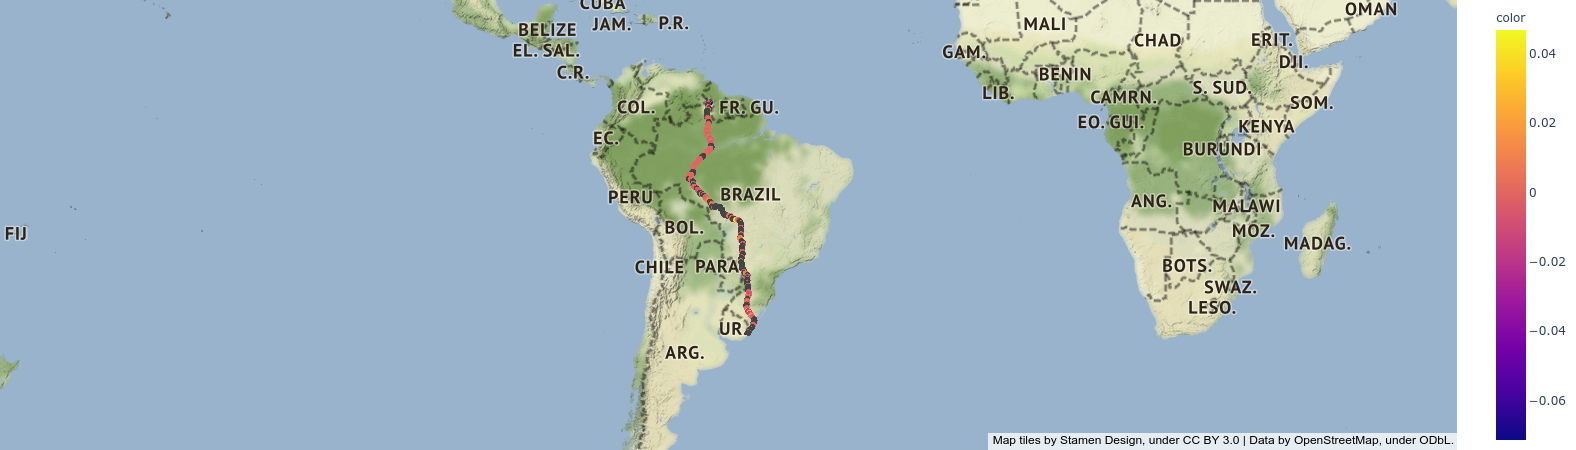

In [75]:
fig = px.scatter_mapbox(lat=df.lat,
                     lon=df.lon,
                     color=grad)
fig.update_layout(mapbox_style="stamen-terrain", 
                  mapbox_center_lat = df.lat.median(),
                  mapbox_zoom=2,
                  margin={"r":0,"t":0,"l":0,"b":0})
fig.show()